In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, operator

## Create necessary classes and functions

Create class to handle "cities"

In [109]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [110]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [111]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Create first "population" (list of routes)

In [112]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

## Create the genetic algorithm

Rank individuals

In [113]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [114]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [115]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [116]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    #child = childP1 + childP2
    child = childP2[:startGene] + childP1 + childP2[startGene:]
    return child

Create function to run crossover over full mating pool

In [117]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Create function to mutate a single route

In [118]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [119]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [120]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [121]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Plot the progress

In [122]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

    showMap(pop[-1])

Run the function with our assumptions to see how distance has improved in each generation

## showMap

In [123]:
def showMap(cityList):
    print(cityList)
    prev=City(0,0)
    for i in cityList:
        plt.plot(i.x, i.y,'ro')
        plt.plot(prev.x,prev.y, 'k-')
        if(prev.x == 0 and prev.y == 0):
            prev=i 
            continue;
        else:
            plt.plot([prev.x,i.x],[prev.y, i.y],'k-')
            prev=i
    plt.show()

## Create list of cities

Artifical samples

In [151]:
cityList = []
for i in range(0,30):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

Real-life samples

In [125]:
cityList = []
with open('att48_xy.txt') as f:
    for line in f:
        cityList.append(City(x=int(line.split()[0]), y=int(line.split()[1])))

## Find indices

In [126]:
cityListRaw = []
with open('att48_xy.txt') as f:
    for line in f:
        cityListRaw.append((int(line.split()[0]), int(line.split()[1])))

In [132]:
def findIndex(cityResult):
    cityResultIndex=[]
    for ix in cityResult:
        cityResultIndex.append(cityList.index(ix))
    return cityResultIndex

## All-in-one

In [133]:
def runGA(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []  
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
          
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    showMap(pop[-1])
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    print(findIndex(bestRoute))

## Running the genetic algorithm

Initial distance: 129466.29038324826


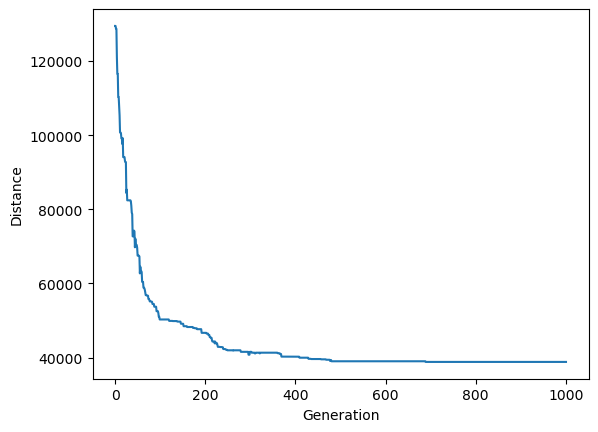

[(10,2676), (1112,2049), (1633,2809), (3245,3305), (4483,3369), (5185,3258), (7248,3779), (7541,3981), (7608,4458), (7762,4595), (7732,4723), (7555,4819), (7611,5184), (7280,4899), (7352,4506), (7573,3716), (7462,3590), (7509,3239), (7545,2801), (7392,2244), (6807,2993), (6426,3173), (5900,3561), (5989,2873), (6347,2683), (6898,1885), (7265,1268), (6734,1453), (6271,2135), (5468,2606), (5199,2182), (4706,2674), (4612,2035), (4307,2322), (3484,2829), (3023,1942), (3082,1644), (1916,1569), (3177,756), (4608,1198), (5530,1424), (6101,1110), (6107,669), (4985,140), (2233,10), (675,1006), (401,841), (23,2216)]


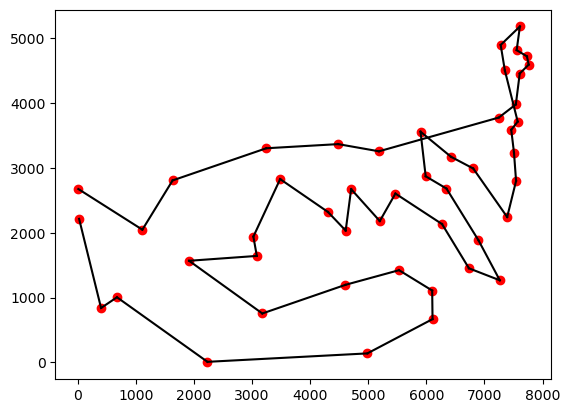

Final distance: 38817.81161006409
[44, 9, 23, 31, 20, 46, 35, 27, 5, 36, 18, 26, 16, 42, 29, 6, 17, 43, 30, 37, 45, 32, 19, 11, 14, 8, 7, 0, 39, 10, 22, 12, 13, 24, 38, 47, 4, 41, 28, 33, 2, 21, 15, 40, 1, 25, 3, 34]


In [136]:
runGA(population=cityList, popSize=100, eliteSize=22, mutationRate=0.0042, generations=1000)

Initial distance: 132698.66215710703


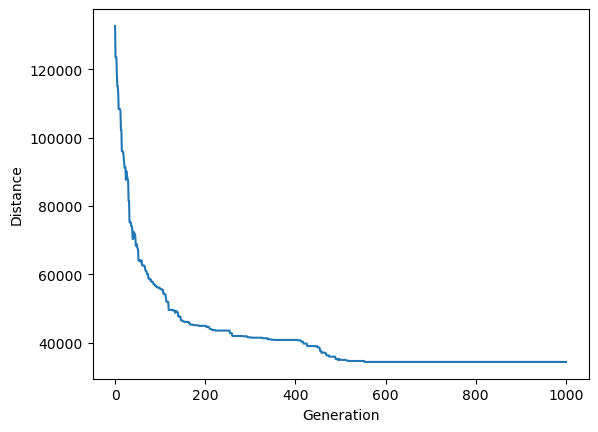

[(3484,2829), (3023,1942), (3082,1644), (1916,1569), (1633,2809), (1112,2049), (10,2676), (23,2216), (401,841), (675,1006), (2233,10), (3177,756), (4985,140), (4608,1198), (5530,1424), (6101,1110), (6107,669), (6734,1453), (7265,1268), (6898,1885), (7392,2244), (7545,2801), (7509,3239), (7462,3590), (7573,3716), (7541,3981), (7608,4458), (7762,4595), (7732,4723), (7555,4819), (7611,5184), (7280,4899), (7352,4506), (7248,3779), (6807,2993), (6426,3173), (6347,2683), (6271,2135), (5989,2873), (5900,3561), (5185,3258), (4706,2674), (4307,2322), (4612,2035), (5199,2182), (5468,2606), (4483,3369), (3245,3305)]


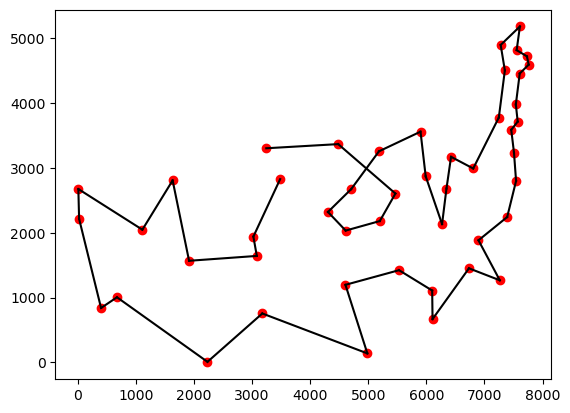

Final distance: 34392.32375156121
[38, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 40, 33, 2, 21, 15, 0, 7, 8, 37, 30, 43, 17, 6, 27, 5, 36, 18, 26, 16, 42, 29, 35, 45, 32, 14, 39, 11, 19, 46, 12, 24, 13, 22, 10, 20, 31]
None


[(3484,2829),
 (3023,1942),
 (3082,1644),
 (1916,1569),
 (1633,2809),
 (1112,2049),
 (10,2676),
 (23,2216),
 (401,841),
 (675,1006),
 (2233,10),
 (3177,756),
 (4985,140),
 (4608,1198),
 (5530,1424),
 (6101,1110),
 (6107,669),
 (6734,1453),
 (7265,1268),
 (6898,1885),
 (7392,2244),
 (7545,2801),
 (7509,3239),
 (7462,3590),
 (7573,3716),
 (7541,3981),
 (7608,4458),
 (7762,4595),
 (7732,4723),
 (7555,4819),
 (7611,5184),
 (7280,4899),
 (7352,4506),
 (7248,3779),
 (6807,2993),
 (6426,3173),
 (6347,2683),
 (6271,2135),
 (5989,2873),
 (5900,3561),
 (5185,3258),
 (4706,2674),
 (4307,2322),
 (4612,2035),
 (5199,2182),
 (5468,2606),
 (4483,3369),
 (3245,3305)]

In [105]:
runGA(population=cityList, popSize=100, eliteSize=22, mutationRate=0.0042, generations=1000)

## Stats
- Initial distance / Final dist = 25.918%
- Final dist / Most optimal dist (answer) = 1.0259

### References

Jessica Y. (2014, Spring). Traveling salesman problems. Northwestern University Open Textbook on Process Optimization.
https://optimization.mccormick.northwestern.edu/index.php/Traveling_salesman_problems

Eric S. (2018, Jul 18). Evolution of a salesman: A complete genetic algorithm tutorial for Python. Towards Data Science.
https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

Gerhard R. TSPLIB - A Traveling Salesman Problem Library, ORSA Journal on Computing, Volume 3, Number 4, Fall 1991, pages 376-384
http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf
https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html

### Attempts

Initial distance: 123584.71835369867


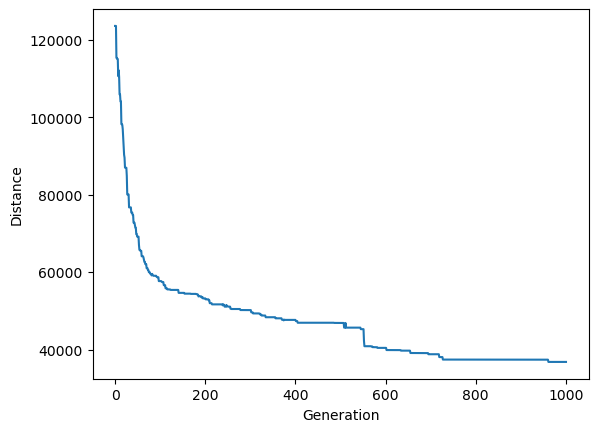

[(7555,4819), (7611,5184), (7280,4899), (7352,4506), (7248,3779), (6807,2993), (6426,3173), (6347,2683), (5989,2873), (5900,3561), (5185,3258), (4483,3369), (3484,2829), (3023,1942), (3082,1644), (4307,2322), (4612,2035), (4608,1198), (5530,1424), (6101,1110), (6107,669), (4985,140), (3177,756), (2233,10), (1916,1569), (1112,2049), (10,2676), (23,2216), (401,841), (675,1006), (1633,2809), (3245,3305), (4706,2674), (5199,2182), (5468,2606), (6271,2135), (6898,1885), (6734,1453), (7265,1268), (7392,2244), (7545,2801), (7509,3239), (7462,3590), (7573,3716), (7541,3981), (7608,4458), (7762,4595), (7732,4723)]


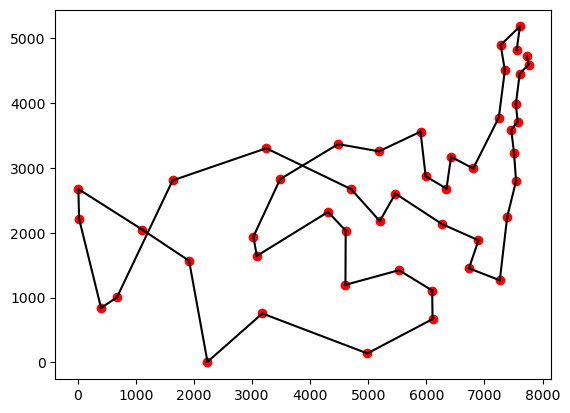

Final distance: 36796.753115880456
[26, 16, 42, 29, 35, 45, 32, 14, 11, 19, 46, 20, 38, 47, 4, 24, 13, 33, 2, 21, 15, 40, 28, 1, 41, 9, 44, 34, 3, 25, 23, 31, 12, 22, 10, 39, 8, 0, 7, 37, 30, 43, 17, 6, 27, 5, 36, 18]


In [150]:
runGA(population=cityList, popSize=100, eliteSize=22, mutationRate=0.0042, generations=1000)

Initial distance: 127167.21524027053


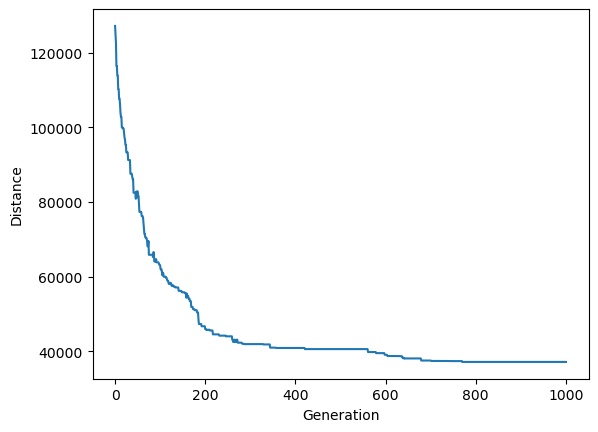

[(7352,4506), (7280,4899), (7611,5184), (7555,4819), (7732,4723), (7762,4595), (7608,4458), (7541,3981), (7573,3716), (7545,2801), (7392,2244), (6898,1885), (7265,1268), (6734,1453), (6101,1110), (6271,2135), (6347,2683), (6807,2993), (7509,3239), (7462,3590), (7248,3779), (6426,3173), (5989,2873), (5468,2606), (5199,2182), (4612,2035), (4307,2322), (3484,2829), (3245,3305), (3023,1942), (3082,1644), (1916,1569), (1633,2809), (1112,2049), (10,2676), (23,2216), (401,841), (675,1006), (2233,10), (3177,756), (4608,1198), (4985,140), (6107,669), (5530,1424), (4706,2674), (4483,3369), (5185,3258), (5900,3561)]


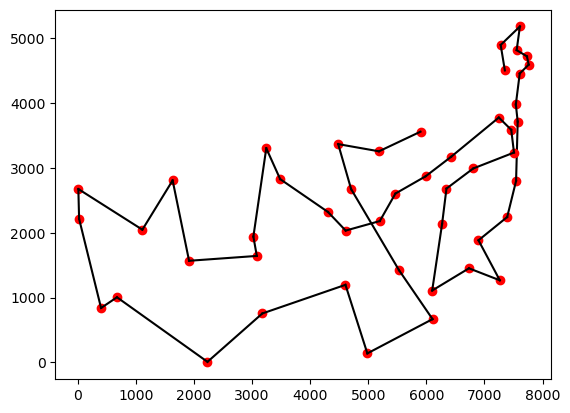

Final distance: 37120.617592987546
[29, 42, 16, 26, 18, 36, 5, 27, 6, 30, 37, 8, 7, 0, 21, 39, 14, 45, 43, 17, 35, 32, 11, 10, 22, 13, 24, 38, 31, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 33, 40, 15, 2, 12, 20, 46, 19]


In [148]:
runGA(population=cityList, popSize=100, eliteSize=22, mutationRate=0.0042, generations=1000)

Initial distance: 2692.837468276672


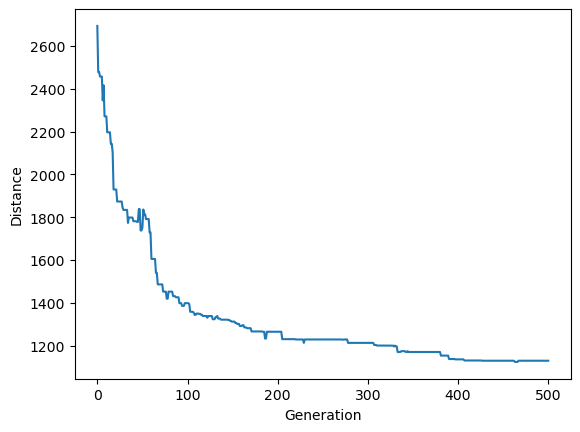

[(51,102), (36,152), (18,179), (5,192), (10,135), (40,120), (40,105), (37,87), (32,26), (63,29), (68,25), (73,76), (65,120), (81,103), (107,107), (171,127), (177,132), (191,142), (144,185), (80,194), (133,178), (139,181), (106,161), (108,138), (199,81), (191,44), (193,16), (186,5), (122,7), (102,43)]


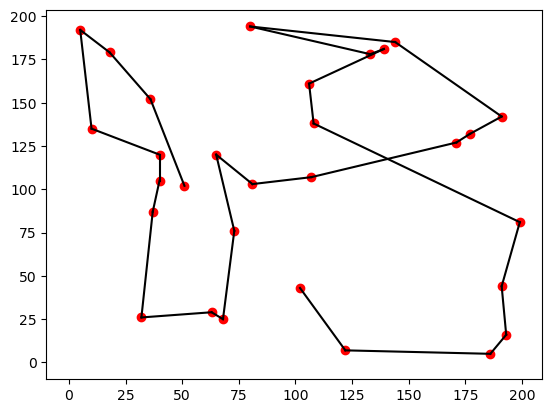

Final distance: 1130.2995031670125
[29, 4, 11, 27, 3, 2, 19, 1, 17, 6, 10, 16, 28, 15, 13, 26, 14, 21, 20, 24, 12, 23, 7, 18, 8, 22, 0, 5, 25, 9]


In [163]:
runGA(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=500)

Initial distance: 2635.8085610504463


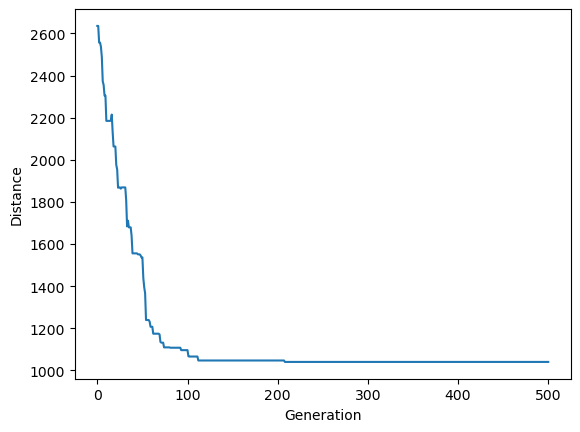

[(5,192), (18,179), (10,135), (36,152), (65,120), (81,103), (107,107), (108,138), (171,127), (177,132), (191,142), (199,81), (191,44), (193,16), (186,5), (122,7), (102,43), (68,25), (63,29), (32,26), (73,76), (37,87), (51,102), (40,105), (40,120), (106,161), (133,178), (139,181), (144,185), (80,194)]


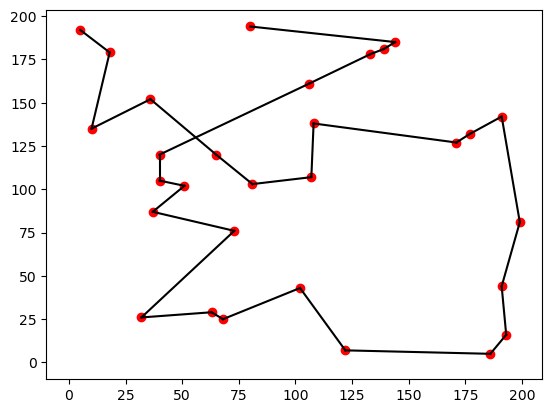

Final distance: 1040.3067550849164
[27, 11, 3, 4, 28, 15, 13, 18, 26, 14, 21, 8, 22, 0, 5, 25, 9, 10, 6, 17, 16, 1, 29, 19, 2, 7, 12, 24, 20, 23]


In [153]:
runGA(population=cityList, popSize=100, eliteSize=10, mutationRate=0.005, generations=500)

Initial distance: 2748.3729142794687


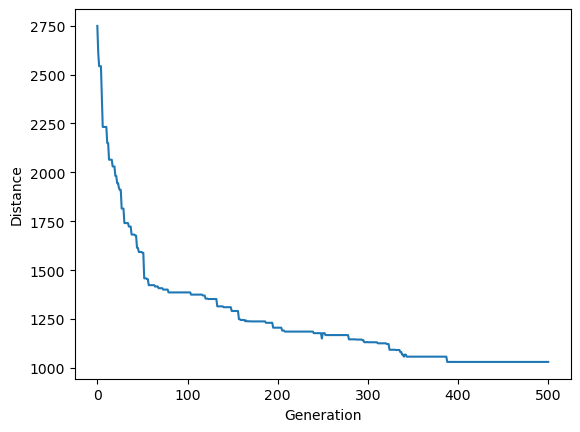

[(18,179), (36,152), (10,135), (73,76), (68,25), (63,29), (32,26), (37,87), (51,102), (40,105), (40,120), (65,120), (81,103), (107,107), (102,43), (122,7), (186,5), (193,16), (191,44), (199,81), (171,127), (177,132), (191,142), (144,185), (139,181), (133,178), (108,138), (106,161), (80,194), (5,192)]


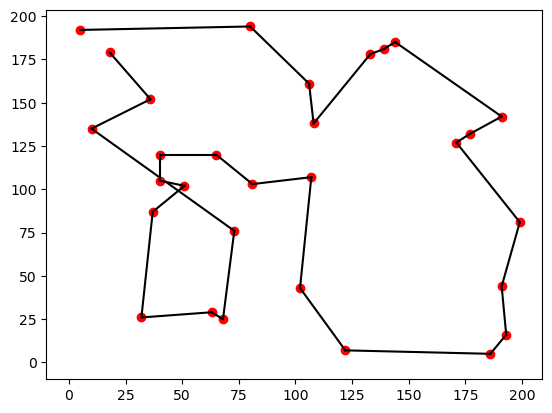

Final distance: 1031.1298506819244
[11, 4, 3, 16, 10, 6, 17, 1, 29, 19, 2, 28, 15, 13, 9, 25, 5, 0, 22, 8, 26, 14, 21, 20, 24, 12, 18, 7, 23, 27]


In [154]:
runGA(population=cityList, popSize=100, eliteSize=10, mutationRate=0.005, generations=500)

Initial distance: 2772.189684024351


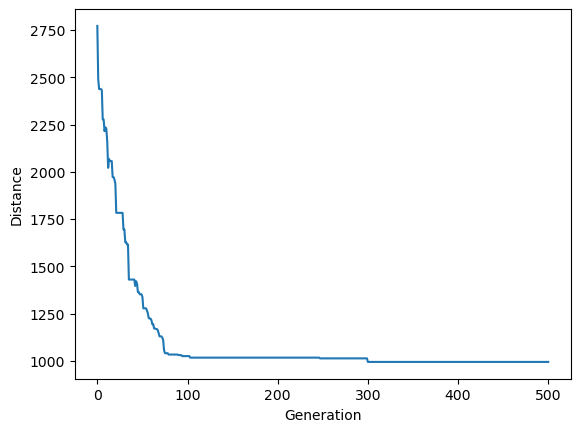

[(5,192), (10,135), (40,120), (65,120), (81,103), (73,76), (51,102), (40,105), (37,87), (32,26), (186,5), (68,25), (102,43), (122,7), (63,29), (193,16), (191,44), (199,81), (171,127), (177,132), (191,142), (144,185), (139,181), (133,178), (80,194), (106,161), (108,138), (107,107), (36,152), (18,179)]


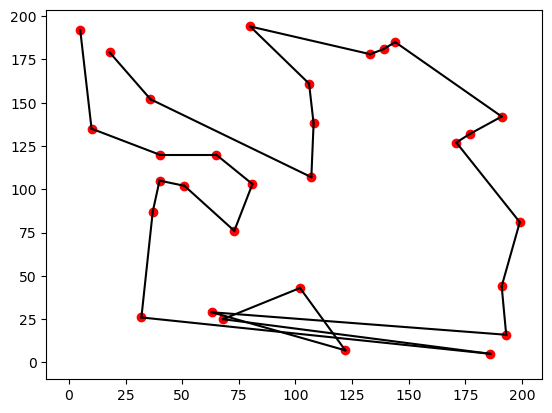

Final distance: 994.4277982719469
[27, 3, 2, 28, 15, 16, 29, 19, 1, 17, 6, 10, 9, 25, 5, 0, 22, 8, 26, 14, 21, 20, 24, 12, 23, 7, 18, 13, 4, 11]


In [160]:
runGA(population=cityList, popSize=100, eliteSize=10, mutationRate=0.005, generations=500)

Initial distance: 2695.1362411976147


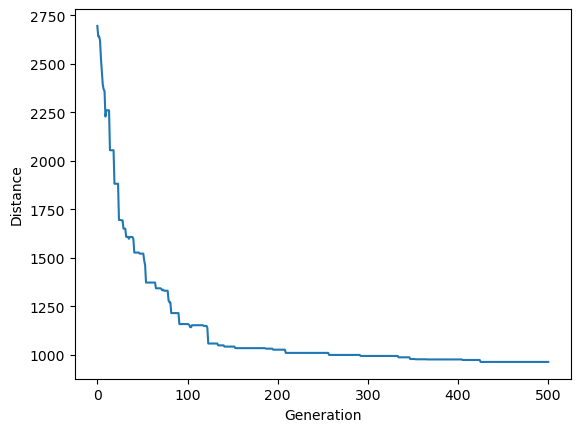

[(139,181), (144,185), (191,142), (177,132), (171,127), (199,81), (191,44), (193,16), (186,5), (122,7), (102,43), (68,25), (63,29), (32,26), (37,87), (40,105), (51,102), (73,76), (107,107), (81,103), (65,120), (40,120), (10,135), (36,152), (18,179), (5,192), (80,194), (106,161), (108,138), (133,178)]


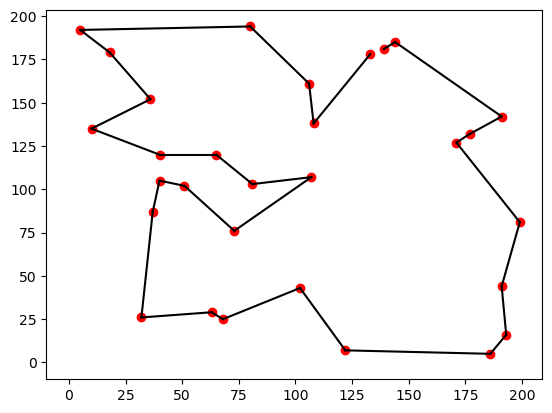

Final distance: 964.1883727508857
[24, 20, 21, 14, 26, 8, 22, 0, 5, 25, 9, 10, 6, 17, 1, 19, 29, 16, 13, 15, 28, 2, 3, 4, 11, 27, 23, 7, 18, 12]


In [161]:
runGA(population=cityList, popSize=100, eliteSize=10, mutationRate=0.005, generations=500)